In [1]:
from google.cloud import bigquery
#https://github.com/vinsburg/alluvial_diagram
import alluvial
from matplotlib import colormaps
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import os
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.lines import Line2D

In [2]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [3]:
client = bigquery.Client(project='subugoe-collaborative')

In [6]:
host = os.environ['KB_HOST']
database = os.environ['KB_DATABASE']
user = os.environ['KB_USER']
pw = os.environ['KB_PASSWORD']
port = os.environ['KB_PORT']
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{database}')

In [7]:
openalex = '`subugoe-collaborative.openalex.works`'
s2 = '`subugoe-wag-closed.S2AG.papers_2023_09_26`'
pm = '`subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022`'
cr = '`subugoe-collaborative.cr_instant.snapshot`'

In [8]:
pubmed_type_mapping = {
    'erratum': ['Published Erratum', 'Retraction of Publication', 'Retracted Publication'],
    'editorial': ['Editorial'],
    'news': ['News'],
    'letter': ['Letter'],
    'review': ['Cochrane Systematic Review', 'Systematic Review', 'Meta-Analysis', 'Review'],
    'article': ['Case Reports', 'Randomized Controlled Trial', 'Clinical Trial', 
                'Clinical Trial, Phase II', 'Clinical Trial, Phase III', 'Clinical Trial, Phase I', 
                'Clinical Trial, Phase IV', 'Controlled Clinical Trial', 'Pragmatic Clinical Trial', 'Journal Article'],
    'funding_info': ['Research Support, Non-U.S. Gov''t', 'Research Support, N.I.H., Extramural', 'Research Support, U.S. Gov''t, Non-P.H.S.', 'Research Support, U.S. Gov''t, P.H.S.',
                    'Research Support, N.I.H., Intramural', 'Research Support, American Recovery and Reinvestment Act'],
    'other': ['Comment', 'Comparative Study', 'Multicenter Study', 'English Abstract', 'Observational Study', 'Evaluation Study',
              'Historical Article', 'Validation Study', 'Introductory Journal Article', 'Video-Audio Media', 'Biography',
              'Practice Guideline', 'Portrait', 'Congress', 'Clinical Trial Protocol', 'Interview', 'Preprint',
              'Personal Narrative', 'Clinical Study', 'Randomized Controlled Trial, Veterinary', 'Consensus Development Conference',
              'Twin Study', 'Overall', 'Patient Education Handout', 'Clinical Trial, Veterinary', 'Guideline',
              'Dataset', 'Lecture', 'Address', 'Clinical Conference', 'Expression of Concern', 'Classical Article',
              'Legal Case', 'Autobiography', 'Technical Report', 'Equivalence Trial', 'Webcast', 'Bibliography',
              'Newspaper Article', 'Observational Study, Veterinary', 'Festschrift', 'Corrected and Republished Article',
              'Consensus Development Conference, NIH', 'Interactive Tutorial', 'Scientific Integrity Review',
              'Duplicate Publication', 'Directory', 'Adaptive Clinical Trial', 'Periodical Index', 'Dictionary',
              'Legislation', 'Evaluation Studies', 'Validation Studies']
}

In [9]:
s2_type_mapping = {
    'erratum': [],
    'editorial': ['Editorial'],
    'news': ['News'],
    'letter': ['LettersAndComments'],
    'review': ['Review', 'MetaAnalysis'],
    'article': ['JournalArticle', 'Study', 'CaseReport', 'ClinicalTrial'],
    'funding_info': [],
    'other': ['Conference', 'Book', 'Dataset']
}

In [10]:
openalex_type_mapping = {
    'erratum': ['erratum'],
    'editorial': ['editorial'],
    'news': [],
    'letter': ['letter'],
    'review': [],
    'article': ['article'],
    'funding_info': ['grant'],
    'other': ['book-chapter', 'dataset', 'paratext', 'book', 'other', 'reference-entry', 'dissertation',
              'report', 'peer-review', 'standard', 'book-series'] 
}

In [11]:
crossref_type_mapping = {
    'erratum': [],
    'editorial': [],
    'news': [],
    'letter': [],
    'review': [],
    'article': ['journal-article', 'proceedings-article'],
    'funding_info': ['grant'],
    'other': ['book-chapter', 'component', 'posted-content', 'dataset', 'other', 'journal-issue', 'book', 'reference-entry', 'peer-review', 'monograph', 
              'report', 'reference-book', 'edited-book', 'proceedings', 'report-component', 'book-section', 'report-series', 'book-part', 'database', 'standard', 'book-track'] 
}

In [12]:
scopus_type_mapping = {
    'erratum': ['Erratum'],
    'editorial': ['Editorial'],
    'news': [],
    'letter': ['Letter'],
    'review': ['Review'],
    'article': ['Article'],
    'funding_info': [],
    'other': ['Conference Paper', 'Chapter', 'Note', 'Short Survey', 'Book', 'Tombstone', 'Data Paper', 'Article in Press', 'Conference Review', 'Abstract Report', 
              'Business Article', 'getItemType: unmatched: pp', 'Report'] 
}

In [13]:
wos_type_mapping = {
    'erratum': ['Correction', 'Retraction', 'Retracted Publication', 'Item Withdrawal'],
    'editorial': ['Editorial Material'],
    'news': ['News Item'],
    'letter': ['Letter'],
    'review': ['Review'],
    'article': ['Article', 'Proceedings Paper'],
    'funding_info': [],
    'other': ['Meeting Abstract', 'Book Review', 'Early Access', 'Biographical-Item', 'Book Chapter', 'Poetry', 'Reprint', 'Data Paper', 'Bibliography', 'Fiction, Creative Prose',
              'Art Exhibit Review', 'Theater Review', 'Software Review', 'CC Meeting Heading', 'Record Review', 'Expression of Concern', 'Film Review', 'Music Performance Review',
              'Music Score Review', 'TV Review, Radio Review', 'Excerpt', 'Database Review', 'Script', 'Hardware Review', 'Dance Performance Review', 'Book', 'Music Score',
              'Chronology', 'Meeting Summary', 'Main Cite', 'Meeting-Abstract', 'Note'] 
}

In [14]:
def mapping_types(mapping_dict, type):
    for k, v in mapping_dict.items():
        if type in v:
            return k

In [15]:
def alluvial_plot(df, db1_column_name, db2_column_name, db1_name, db2_name, image_name, width, height):
    df.fillna('other', inplace=True)
    d = {}
    for row in df.to_dict('records'):
        db1_type = row[db1_column_name] + ' (' + db1_name + ')'
        db2_type = row[db2_column_name] + ' (' + db2_name + ')'
        n = row['n']
    
        dd = {}
        dd[db2_type] = n
        
        if db1_type in d:
            d[db1_type].update(dd)
        else:
            d[db1_type] = dd

    d = {k + ' ': v for k, v in d.items()}

    cmap = colormaps['gist_earth']

    ax = alluvial.plot(d, alpha=0.4, cmap=cmap, fontname='Arial')
    fig = ax.get_figure()
    fig.set_size_inches(width, height)
    plt.show()
    fig.savefig(f'media/{image_name}.png', format='png', bbox_inches='tight', dpi=500)

In [16]:
def alluvial_plot_new_types(df, db1_column_name, db2_column_name, db1_name, db2_name, db1_mapping, db2_mapping, image_name, width, height):
    df2 = df.copy()
    df2['db1_new_type'] = df2.apply(lambda row : mapping_types(db1_mapping, row[db1_column_name]), axis=1)
    df2['db2_new_type'] = df2.apply(lambda row : mapping_types(db2_mapping, row[db2_column_name]), axis=1)

    df2.fillna('other', inplace=True)

    d = {}
    for row in df2.to_dict('records'):
        db1_type = row['db1_new_type'] + ' (' + db1_name + ')'
        db2_type = row['db2_new_type'] + ' (' + db2_name + ')'
        current_r = row['db1_new_type'] + ' (' + db1_name + ')'
        n = row['n']
    
        if current_r in d:
            if db2_type in d[db1_type].keys():
                d[db1_type][db2_type] = d.get(db1_type).get(db2_type) + n
            else:
                 d[db1_type][db2_type] = n
        else:
            dd = {}
            dd[db2_type] = n
            d[db1_type] = dd

    cmap = colormaps['gist_earth']

    ax = alluvial.plot(d, alpha=0.4, cmap=cmap, fontname='Arial')
    fig = ax.get_figure()
    fig.set_size_inches(width, height)
    plt.show()
    fig.savefig(f'media/{image_name}.png', format='png', bbox_inches='tight', dpi=500)

In [17]:
openalex_doctypes = client.query(f"""
                                  SELECT type AS doctype, COUNT(DISTINCT(doi)) AS n
                                  FROM {openalex}  
                                  GROUP BY doctype
                                  ORDER BY n DESC
                                  """).to_dataframe()

In [18]:
openalex_doctypes

,doctype,n
0,article,118696451
1,book-chapter,20474261
2,dataset,3078055
3,paratext,2764177
4,book,1851855
5,other,1194707
6,reference-entry,1017368
7,dissertation,934523
8,report,774256
9,peer-review,429031


In [19]:
openalex_doctypes['new_type'] = openalex_doctypes.apply(lambda row: mapping_types(openalex_type_mapping, 
                                                                                  row['doctype']), axis=1)

In [20]:
openalex_doctypes.groupby(['new_type'])['n'].sum().reset_index()

,new_type,n
0,article,118696451
1,editorial,277287
2,erratum,191997
3,funding_info,89256
4,letter,54310
5,other,32897895


In [21]:
pm_doctypes = client.query(f"""
                            SELECT ptype AS pm_doctypes, COUNT(DISTINCT(doi)) AS n
                            FROM {pm} AS pm
                            GROUP BY pm_doctypes
                            ORDER BY n DESC
                            """).to_dataframe()

In [22]:
pm_doctypes

,pm_doctypes,n
0,Journal Article,18041945
1,"Research Support, Non-U.S. Gov''t",5843529
2,Review,1970486
3,"Research Support, N.I.H., Extramural",1352844
4,Case Reports,1069817
...,...,...
74,Periodical Index,23
75,Legislation,21
76,None,15
77,Scientific Integrity Review,8


In [23]:
pm_doctypes['new_type'] = pm_doctypes.apply(lambda row : mapping_types(pubmed_type_mapping, 
                                                                       row['pm_doctypes']), axis=1)
pm_doctypes.groupby(['new_type'])['n'].sum().reset_index()

,new_type,n
0,article,19794158
1,editorial,441286
2,erratum,144579
3,funding_info,1418943
4,letter,678745
5,news,107528
6,other,2869224
7,review,2350953


In [24]:
openalex_pm_doctypes = client.query(f"""
                                    SELECT type AS oalex_type, ptype AS pm_doctypes, COUNT(DISTINCT(oalex.doi)) AS n
                                    FROM {pm} AS pm
                                    JOIN {openalex} AS oalex
                                    ON LOWER(oalex.doi) = LOWER(pm.doi)
                                    GROUP BY oalex_type, pm_doctypes
                                    ORDER BY oalex_type, pm_doctypes
                                    """).to_dataframe()

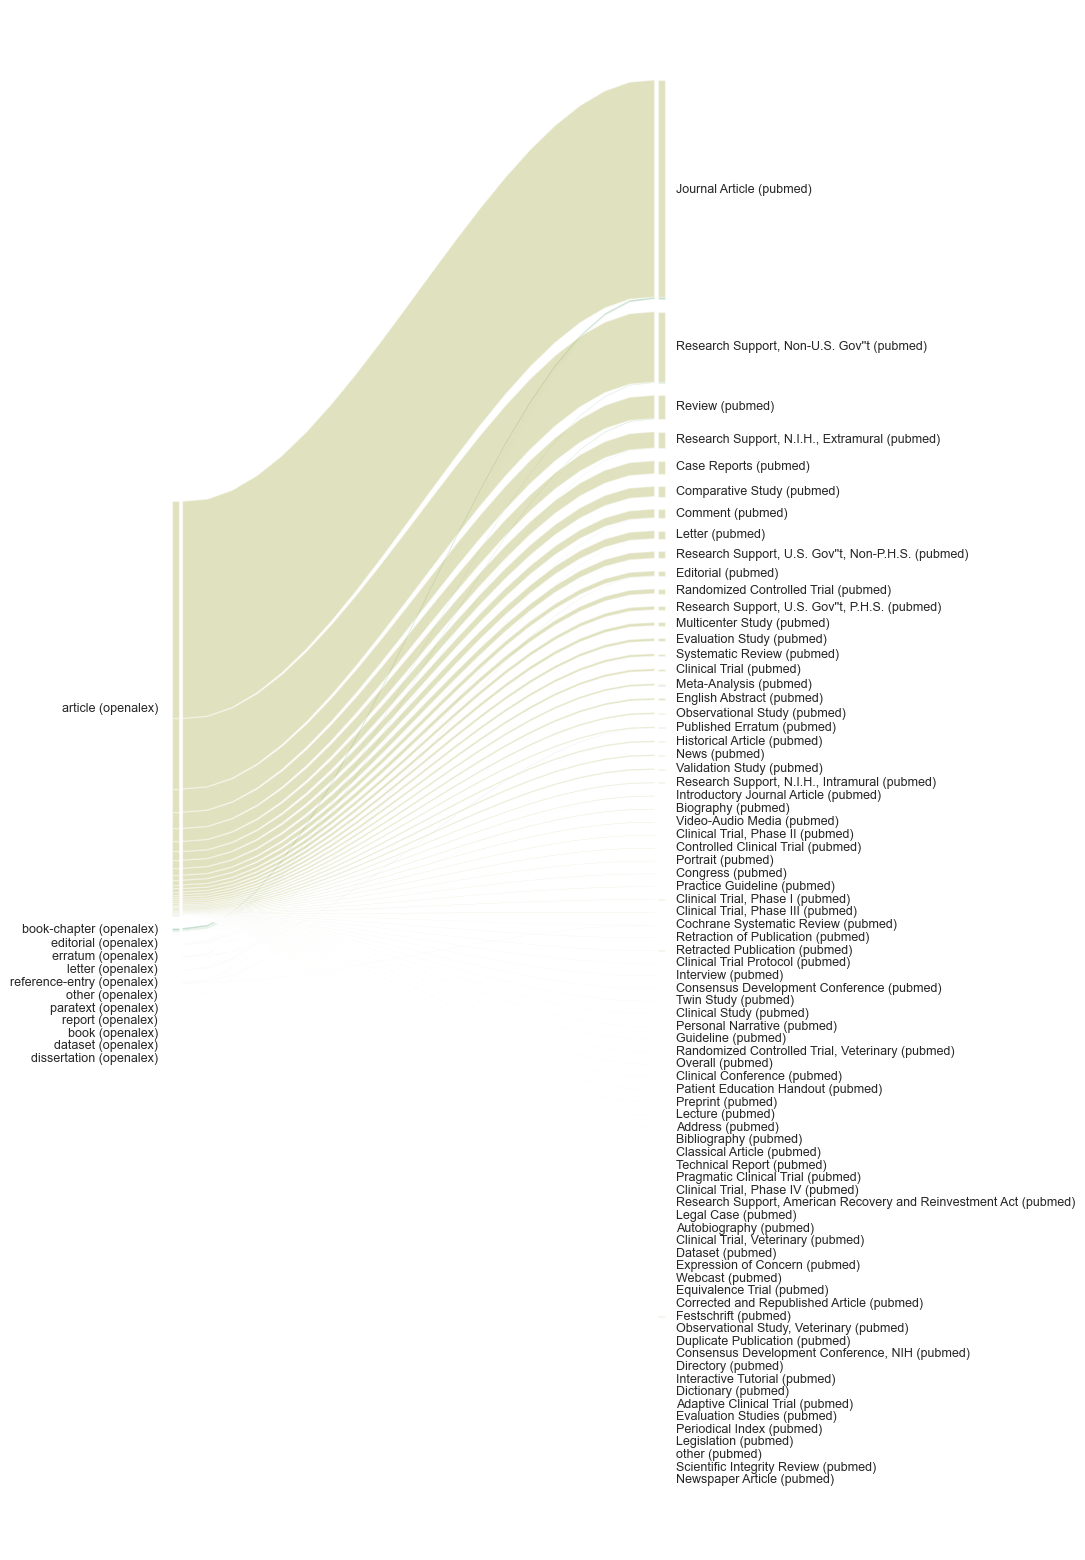

In [25]:
alluvial_plot(openalex_pm_doctypes, 'oalex_type', 'pm_doctypes', 'openalex', 'pubmed', 'openalex_pubmed', 7, 20)

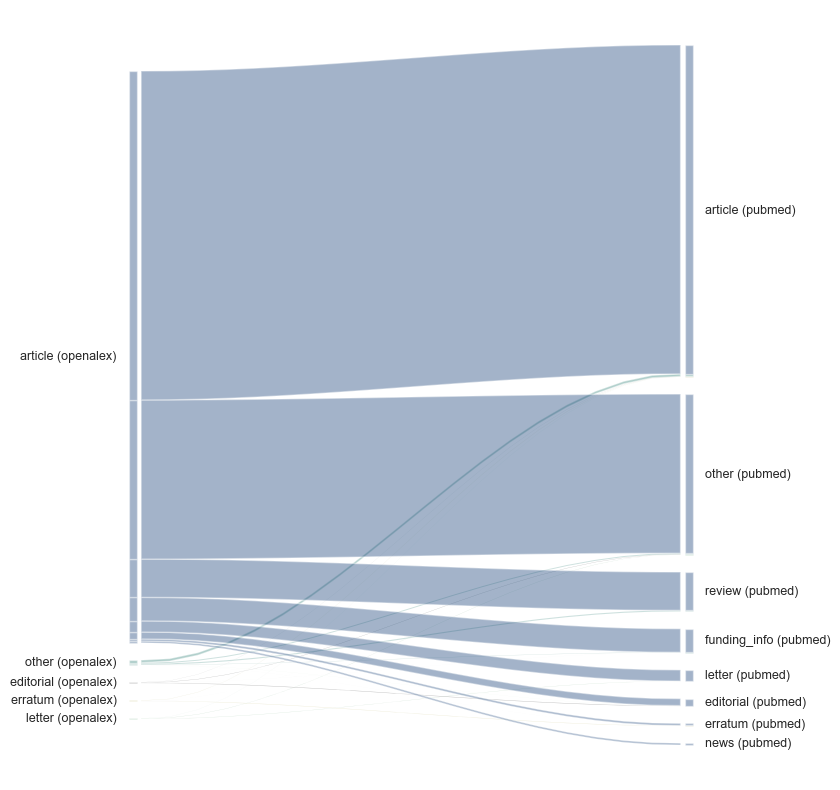

In [26]:
alluvial_plot_new_types(openalex_pm_doctypes, 'oalex_type', 'pm_doctypes', 'openalex', 'pubmed', openalex_type_mapping, pubmed_type_mapping, 'openalex_pubmed_new_clas', 8, 10)

In [27]:
s2_doctypes = client.query(f"""
                            SELECT s2_pubtypes as s2_doctype, COUNT(DISTINCT(externalids.DOI)) AS n
                            FROM {s2} AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                            GROUP BY s2_pubtypes
                            ORDER BY n DESC
                            """).to_dataframe()

In [28]:
s2_doctypes

,s2_doctype,n
0,JournalArticle,34241462
1,Review,10618917
2,Conference,3874850
3,Study,1876313
4,CaseReport,1524572
5,LettersAndComments,1298025
6,Editorial,574586
7,ClinicalTrial,460394
8,Book,313607
9,News,148077


In [29]:
s2_oalex_doctypes = client.query(f"""
                                  SELECT type AS oalex_type, s2_pubtypes as s2_doctype, COUNT(DISTINCT(doi)) AS n
                                  FROM {s2} AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                                  JOIN {openalex} AS oalex
                                  ON LOWER(oalex.doi) = LOWER(s2.externalids.DOI)
                                  GROUP BY oalex_type, s2_doctype
                                  ORDER BY oalex_type, s2_doctype
                                  """).to_dataframe()

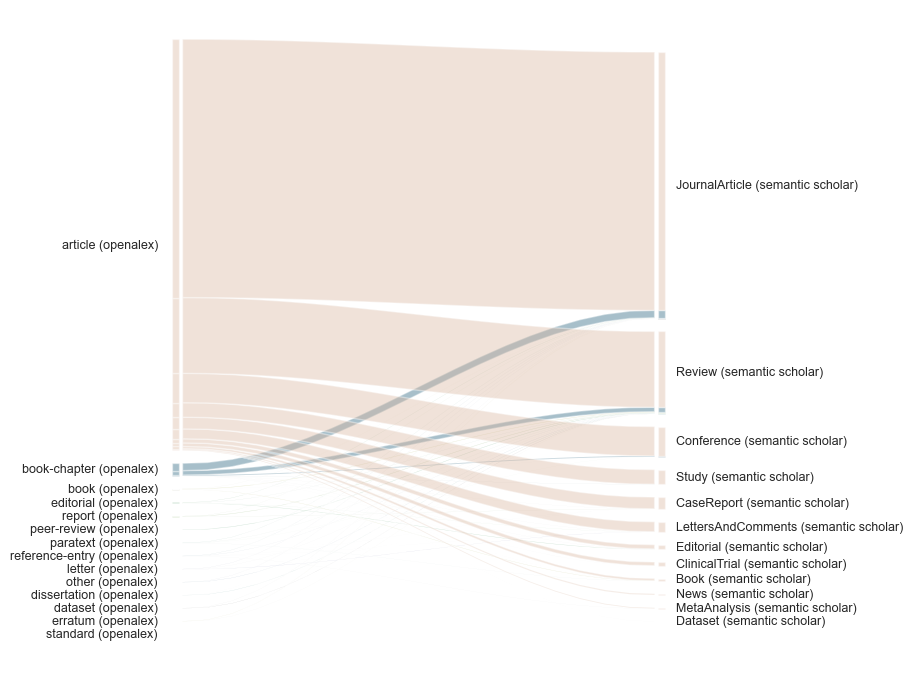

In [30]:
alluvial_plot(s2_oalex_doctypes, 'oalex_type', 's2_doctype', 'openalex', 'semantic scholar', 'openalex_s2', 7, 8.5)

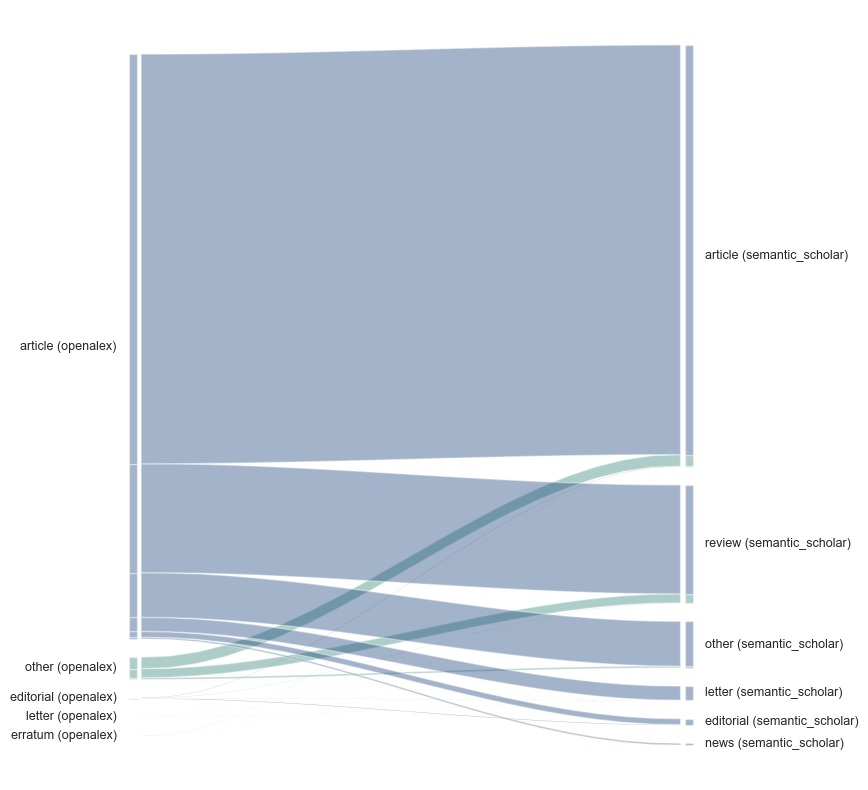

In [31]:
alluvial_plot_new_types(s2_oalex_doctypes, 'oalex_type', 's2_doctype', 'openalex', 'semantic_scholar', openalex_type_mapping, s2_type_mapping, 'openalex_s2_new_clas', 8, 10)

In [32]:
s2_pm_pubtypes = client.query(f"""
                               SELECT ptype AS pm_type, s2_pubtypes AS s2_doctype, COUNT(DISTINCT(doi)) AS n
                               FROM {s2} AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                               JOIN {pm} AS pm
                               ON LOWER(pm.doi) = LOWER(s2.externalids.DOI)
                               GROUP BY pm_type, s2_doctype
                               ORDER BY pm_type, s2_doctype
                               """).to_dataframe()

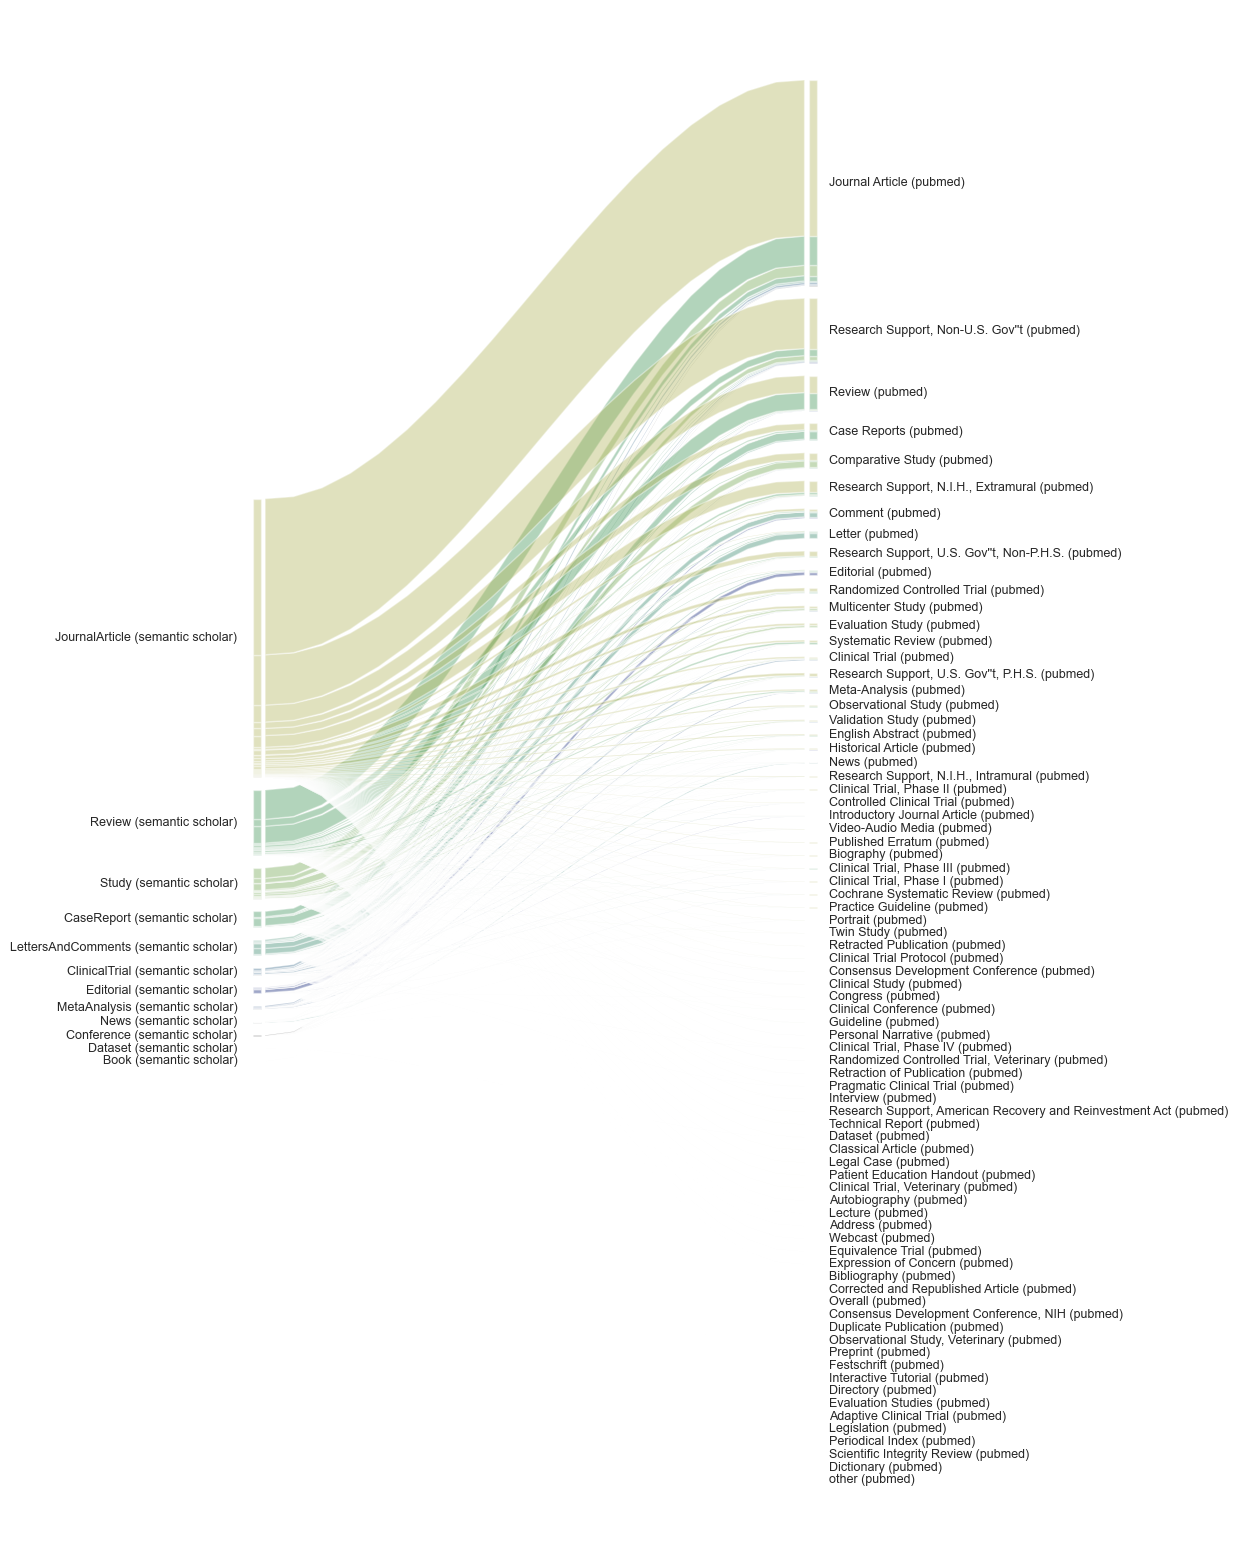

In [33]:
alluvial_plot(s2_pm_pubtypes, 's2_doctype', 'pm_type', 'semantic scholar', 'pubmed', 's2_pubmed', 8, 20)

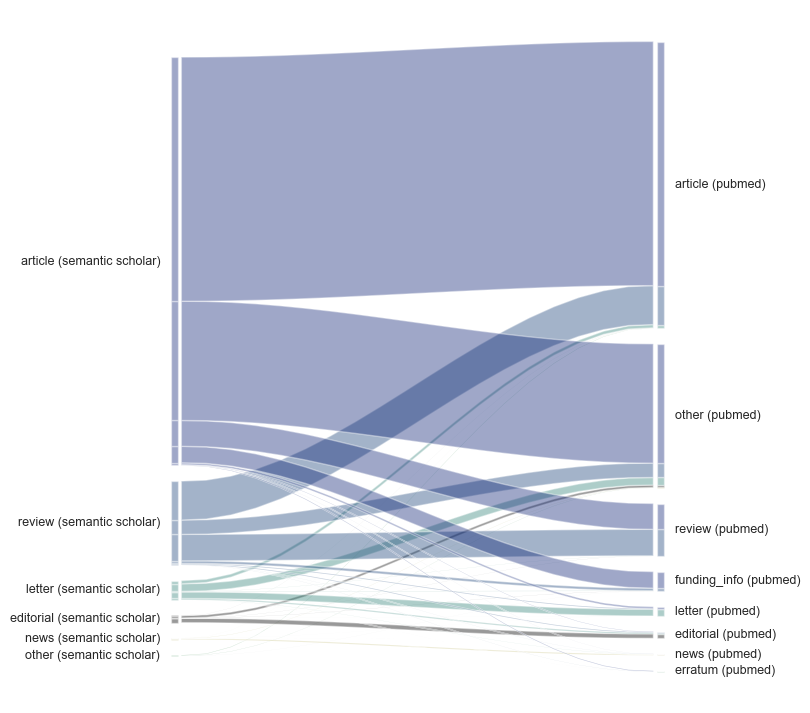

In [34]:
alluvial_plot_new_types(s2_pm_pubtypes, 's2_doctype', 'pm_type', 'semantic scholar', 'pubmed', s2_type_mapping, pubmed_type_mapping, 's2_pm_new_clas', 7, 9)

In [35]:
scp_type = pd.read_sql("""
                 SELECT unnest(item_type) AS scp_type, COUNT(DISTINCT(doi)) AS n
                 FROM scp_b_202307.items i
                 GROUP BY scp_type
                 ORDER BY n DESC
                 """, 
                 con=engine)

In [36]:
scp_type

,scp_type,n
0,Article,37825395
1,Conference Paper,7595561
2,Review,3179991
3,Chapter,1791951
4,Editorial,1001710
5,Letter,903080
6,Note,878918
7,Erratum,360111
8,Short Survey,250187
9,Book,233774


In [37]:
oalex_scp_type = pd.read_sql("""
                 SELECT w.type AS oalex_type, unnest(item_type) AS scp_type, COUNT(DISTINCT(w.doi)) AS n
                 FROM fiz_openalex_rep_20231123.works w
                 JOIN scp_b_202307.items i
                 ON LOWER(TRIM('https://doi.org/' FROM w.doi)) = LOWER(i.doi)
                 GROUP BY oalex_type, scp_type
                 """, 
                 con=engine)

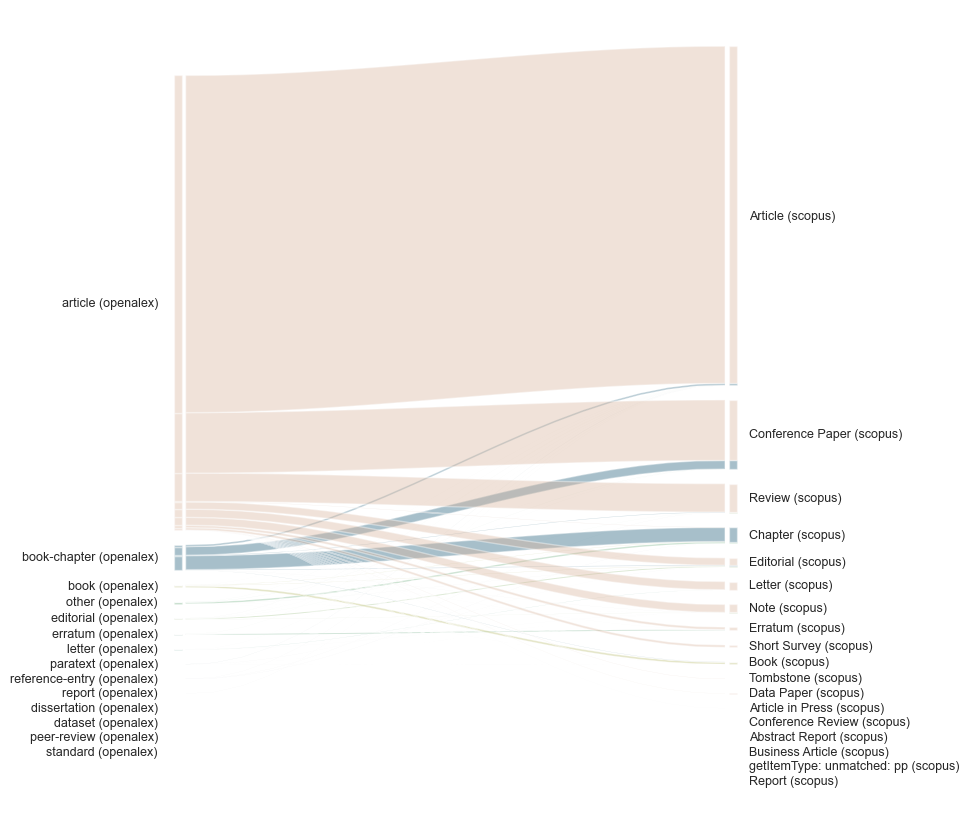

In [38]:
alluvial_plot(oalex_scp_type, 'oalex_type', 'scp_type', 'openalex', 'scopus', 'openalex_scp', 8, 10.5)

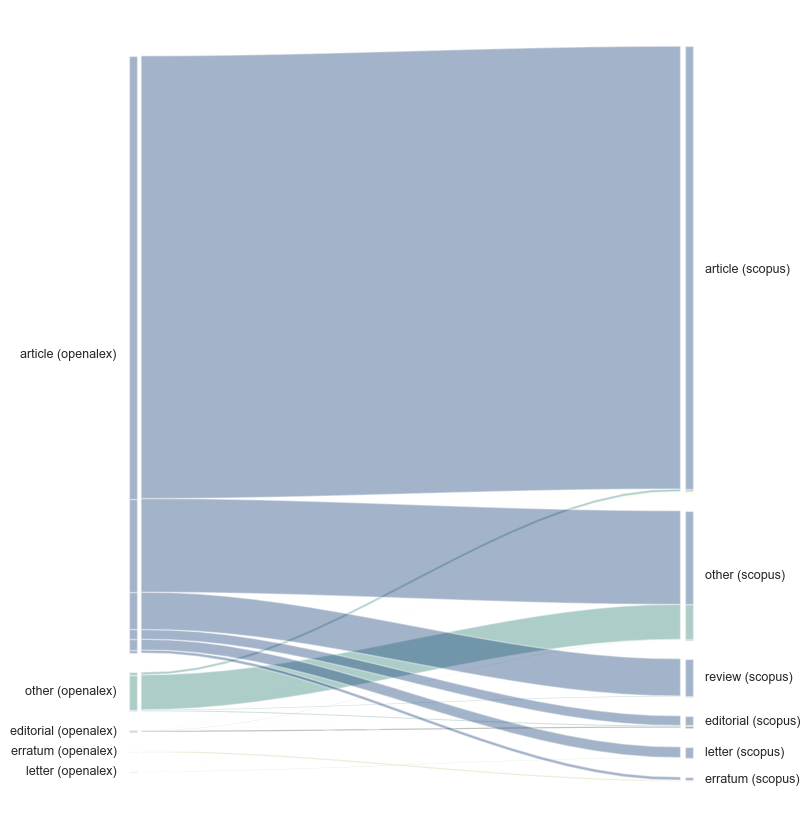

In [39]:
alluvial_plot_new_types(oalex_scp_type, 'oalex_type', 'scp_type', 'openalex', 'scopus', openalex_type_mapping, scopus_type_mapping, 'openalex_scp_new_clas',8, 10.5)

In [40]:
cr_doctypes = pd.read_sql("""
                          SELECT type, COUNT(DISTINCT(doi)) AS n
                          FROM open_add_ons.cr_oct2023
                          GROUP BY type
                          ORDER BY n DESC
                          """, 
                          con=engine)

In [41]:
cr_doctypes

,type,n
0,journal-article,52258281
1,book-chapter,11671395
2,proceedings-article,5147384
3,component,2016645
4,posted-content,1633493
5,dataset,1292712
6,other,812351
7,journal-issue,676926
8,book,607251
9,reference-entry,492140


In [42]:
cr_openalex_doctypes = pd.read_sql("""
                                   SELECT cr.type AS cr_doctype, oalex_w.type AS oalex_type, COUNT(DISTINCT(cr.doi)) AS n
                                   FROM open_add_ons.cr_oct2023 AS cr
                                   JOIN fiz_openalex_rep_20231123.works AS oalex_w
                                   ON LOWER(cr.doi) = LOWER(TRIM('https://doi.org/' FROM oalex_w.doi))
                                   GROUP BY cr_doctype, oalex_type
                                   ORDER BY n DESC
                                   """, 
                                   con=engine)

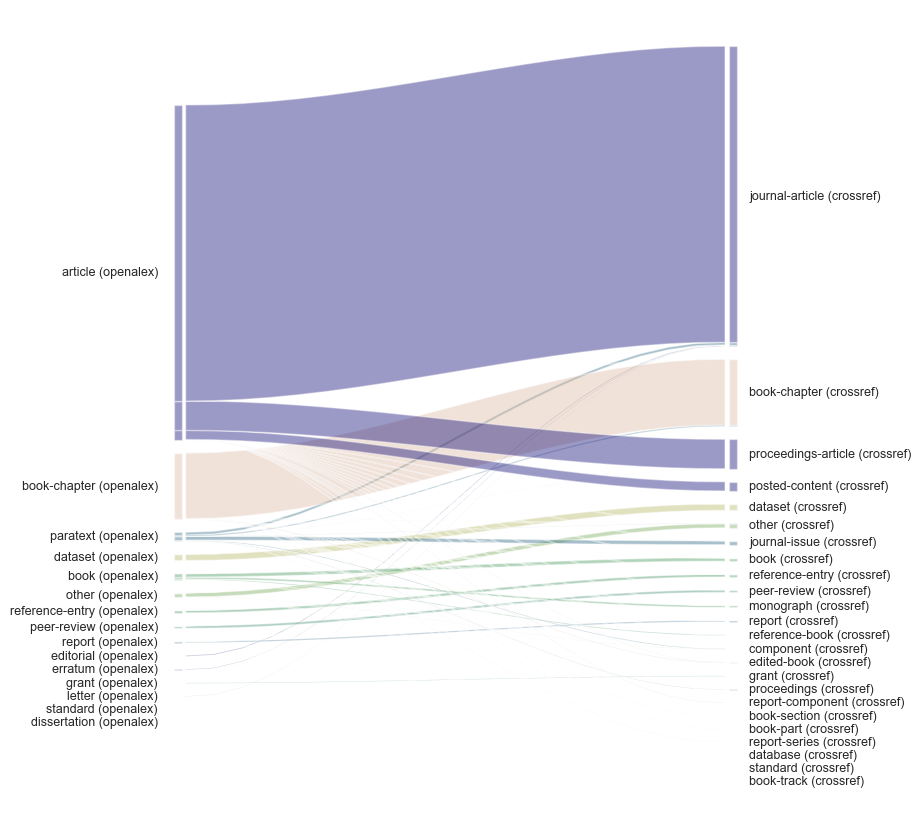

In [43]:
alluvial_plot(cr_openalex_doctypes, 'oalex_type', 'cr_doctype', 'openalex', 'crossref', 'openalex_cr', 8, 10.5)

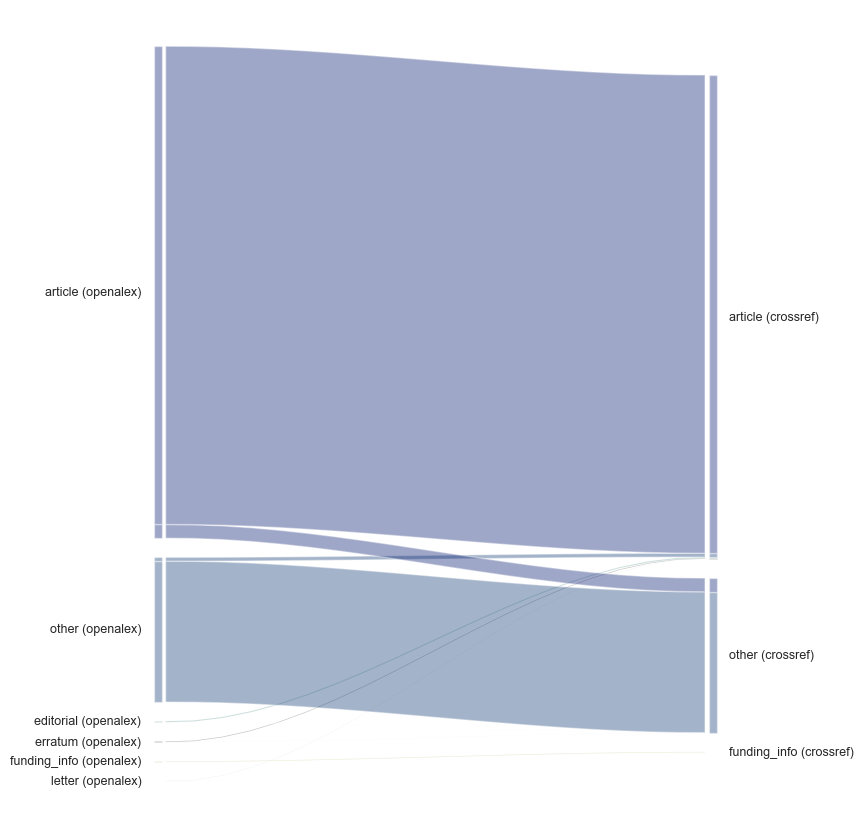

In [44]:
alluvial_plot_new_types(cr_openalex_doctypes, 'oalex_type', 'cr_doctype', 'openalex', 'crossref', openalex_type_mapping, crossref_type_mapping,'openalex_cr_new_clas', 8, 10.5)

In [45]:
wos_type = pd.read_sql("""
                 SELECT unnest(item_type) AS wos_type, COUNT(DISTINCT(doi)) AS n
                 FROM wos_b_202307.v_items i
                 GROUP BY wos_type
                 ORDER BY n DESC
                 """, 
                 con=engine)

In [46]:
wos_type

,wos_type,n
0,Article,28869631
1,Proceedings Paper,3642816
2,Review,1928586
3,Editorial Material,1621620
4,Meeting Abstract,1267651
5,Letter,793187
6,Book Review,666937
7,Early Access,364365
8,Correction,278804
9,News Item,125565


In [47]:
oalex_wos_type = pd.read_sql("""
                     SELECT w.type AS oalex_type, unnest(item_type) AS wos_type, COUNT(DISTINCT(w.doi)) AS n
                     FROM fiz_openalex_rep_20231123.works w
                     JOIN wos_b_202307.v_items i
                     ON LOWER(TRIM('https://doi.org/' FROM w.doi)) = LOWER(i.doi)
                     GROUP BY oalex_type, wos_type
                     """, 
                     con=engine)

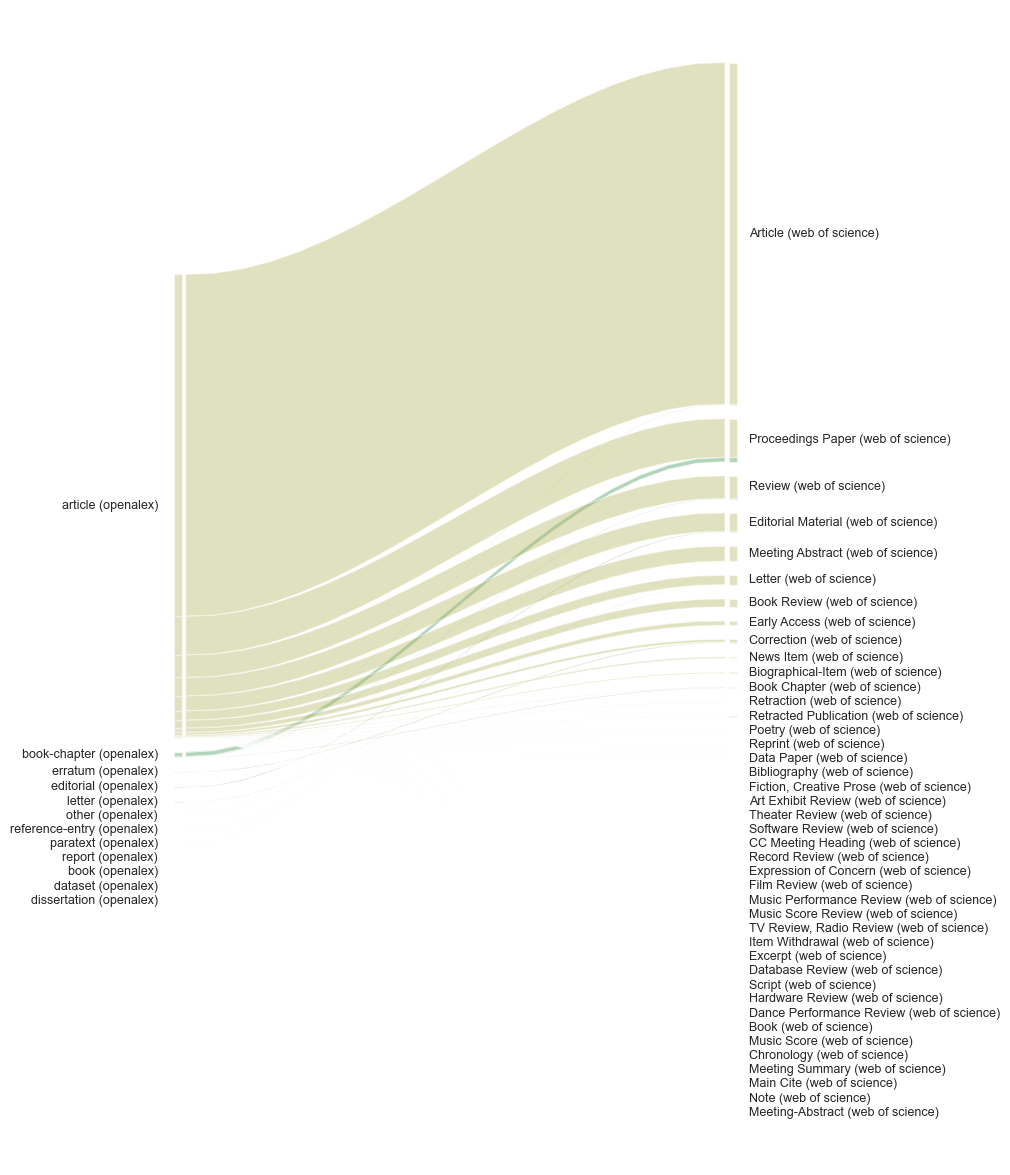

In [48]:
alluvial_plot(oalex_wos_type, 'oalex_type', 'wos_type', 'openalex', 'web of science', 'openalex_wos', 8, 15)

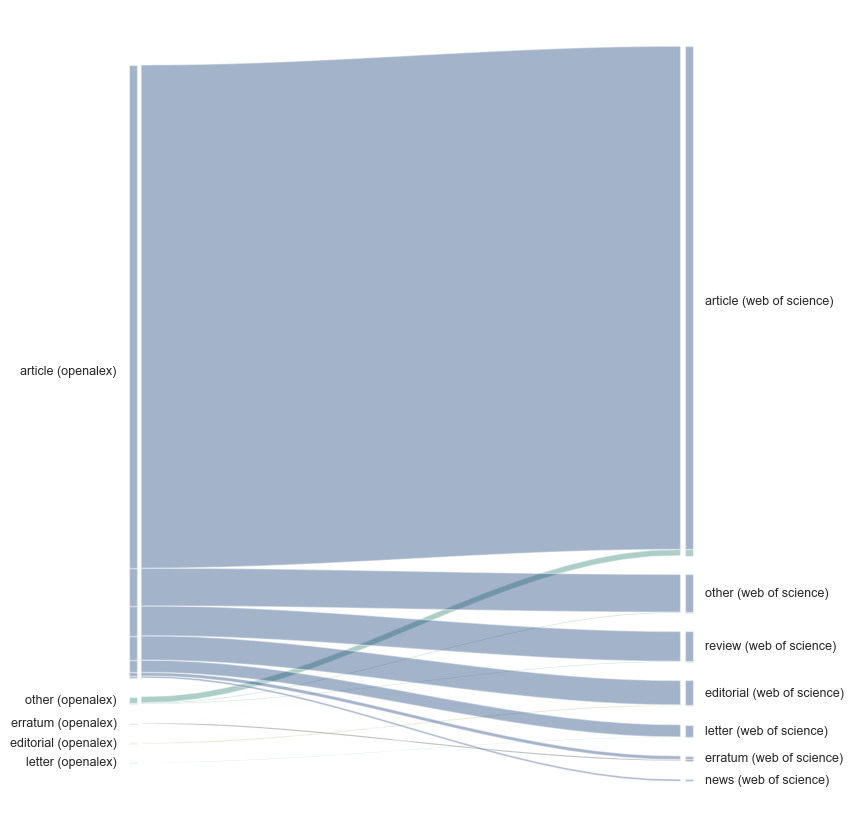

In [49]:
alluvial_plot_new_types(oalex_wos_type, 'oalex_type', 'wos_type', 'openalex', 'web of science', openalex_type_mapping, wos_type_mapping, 'openalex_wos_new_clas', 8, 10.5)

In [50]:
openalex_pm_doctypes_editorial = client.query(f"""
                SELECT oalex.type AS oalex_type, ptype AS pm_doctypes, COUNT(DISTINCT(oalex.doi)) AS n
                FROM `subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022` AS pm
                JOIN `subugoe-collaborative.openalex.works` AS oalex
                ON LOWER(oalex.doi) = LOWER(pm.doi)
                WHERE ptype IN ("Editorial", "Letter", "News")
                GROUP BY oalex_type, pm_doctypes
                ORDER BY n DESC
                """).to_dataframe()

In [51]:
openalex_pm_doctypes_editorial

,oalex_type,pm_doctypes,n
0,article,Letter,663412
1,article,Editorial,412524
2,article,News,107408
3,editorial,Editorial,27105
4,letter,Letter,14339
5,book-chapter,Editorial,869
6,erratum,Letter,115
7,reference-entry,Editorial,105
8,letter,Editorial,100
9,editorial,Letter,74


In [52]:
openalex_pm_doctypes_pubyear = client.query(f"""
                SELECT ptype AS pm_doctypes, publication_year, COUNT(DISTINCT(oalex.doi)) AS n
                FROM `subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022` AS pm
                JOIN `subugoe-collaborative.openalex.works` AS oalex
                ON LOWER(oalex.doi) = LOWER(pm.doi)
                WHERE ptype IN ("Editorial", "Letter", "News") AND publication_year BETWEEN 1995 AND 2022
                GROUP BY pm_doctypes, publication_year
                ORDER BY publication_year, n DESC
                """).to_dataframe()

In [53]:
openalex_pm_doctypes_pubyear

,pm_doctypes,publication_year,n
0,Letter,1995,283
1,Editorial,1995,104
2,News,1995,13
3,Letter,1996,251
4,Editorial,1996,104
...,...,...,...
79,Editorial,2021,35952
80,News,2021,5238
81,Letter,2022,34688
82,Editorial,2022,32942


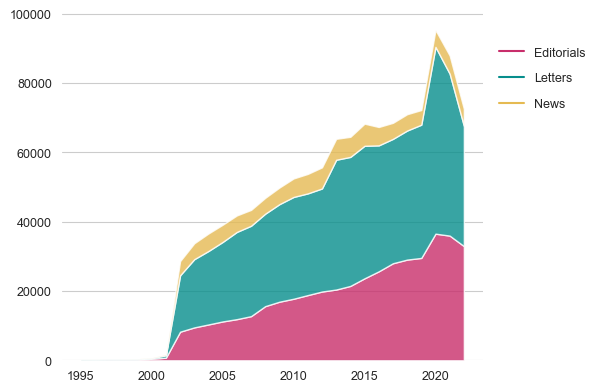

In [54]:
fig, ax = plt.subplots(figsize=(5,4))

plt.box(False)

pubyears = np.array(list(set(openalex_pm_doctypes_pubyear.publication_year.tolist())), dtype=float)
editorials = np.array(openalex_pm_doctypes_pubyear[openalex_pm_doctypes_pubyear.pm_doctypes == 'Editorial'].n.tolist(), dtype=float)
letters = np.array(openalex_pm_doctypes_pubyear[openalex_pm_doctypes_pubyear.pm_doctypes == 'Letter'].n.tolist(), dtype=float)
news = np.array(openalex_pm_doctypes_pubyear[openalex_pm_doctypes_pubyear.pm_doctypes == 'News'].n.tolist(), dtype=float)

plt.stackplot(pubyears, editorials, letters, news,
              colors =['#C82E6B', '#068E8C', '#E5BA52'], alpha=0.8)

ax.grid(False, which='both', axis='x')

editorials_patch = Line2D([0], [0], color='#C82E6B', label='Editorials')
letters_patch = Line2D([0], [0], color='#068E8C', label='Letters')
news_patch = Line2D([0], [0], color='#E5BA52', label='News')

lgd = fig.legend(handles=[editorials_patch, letters_patch, news_patch], frameon=False,
                 bbox_to_anchor=(1.2, 0.9), labelspacing=1.1)
plt.tight_layout()
plt.show()

In [55]:
openalex_doctypes_pubyear = client.query(f"""
                SELECT type, publication_year, COUNT(DISTINCT(oalex.doi)) AS n
                FROM `subugoe-collaborative.openalex.works` AS oalex
                WHERE type IN ("editorial", "letter", "news") AND publication_year BETWEEN 1995 AND 2022
                GROUP BY type, publication_year
                ORDER BY publication_year, n DESC
                """).to_dataframe()

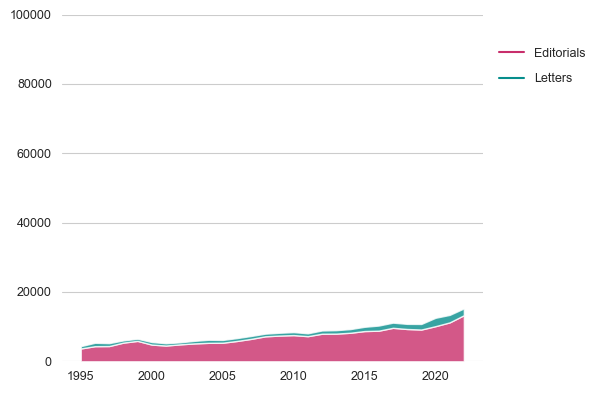

In [56]:
fig, ax = plt.subplots(figsize=(5,4))

plt.box(False)

pubyears = np.array(list(set(openalex_doctypes_pubyear.publication_year.tolist())), dtype=float)
editorials = np.array(openalex_doctypes_pubyear[openalex_doctypes_pubyear.type == 'editorial'].n.tolist(), dtype=float)
letters = np.array(openalex_doctypes_pubyear[openalex_doctypes_pubyear.type == 'letter'].n.tolist(), dtype=float)

plt.plot([], [], color ='r', 
         label ='editorials')
plt.plot([], [], color ='c',
         label ='letters')

plt.stackplot(pubyears, editorials, letters, 
              colors =['#C82E6B', '#068E8C'], alpha=0.8)

ax.grid(False, which='both', axis='x')

ax.set_ylim(0, 100000)

editorials_patch = Line2D([0], [0], color='#C82E6B', label='Editorials')
letters_patch = Line2D([0], [0], color='#068E8C', label='Letters')

lgd = fig.legend(handles=[editorials_patch, letters_patch], frameon=False,
                 bbox_to_anchor=(1.2, 0.9), labelspacing=1.1)
plt.tight_layout()
plt.show()

In [57]:
s2_doctypes_pubyear = client.query(f"""
                SELECT s2_pubtypes as s2_doctype, year, COUNT(DISTINCT(s2.externalids.DOI)) AS n
                FROM {s2} AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                WHERE s2_pubtypes IN ("Editorial", "LettersAndComments", "News") 
                    AND year BETWEEN 1995 AND 2022
                GROUP BY s2_doctype, year
                ORDER BY year, n DESC
                """).to_dataframe()

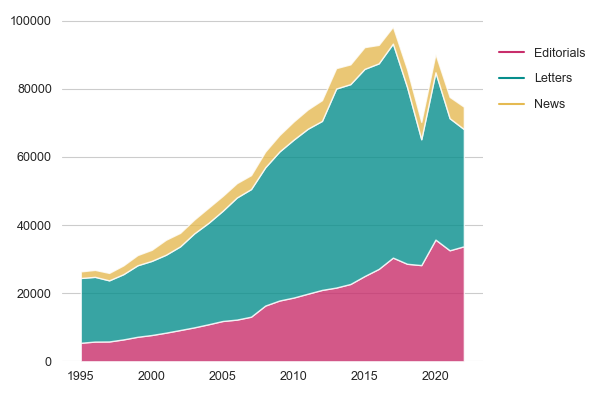

In [58]:
fig, ax = plt.subplots(figsize=(5,4))

plt.box(False)

pubyears = np.array(list(set(s2_doctypes_pubyear.year.tolist())), dtype=float)
editorials = np.array(s2_doctypes_pubyear[s2_doctypes_pubyear.s2_doctype == 'Editorial'].n.tolist(), dtype=float)
letters = np.array(s2_doctypes_pubyear[s2_doctypes_pubyear.s2_doctype == 'LettersAndComments'].n.tolist(), dtype=float)
news = np.array(s2_doctypes_pubyear[s2_doctypes_pubyear.s2_doctype == 'News'].n.tolist(), dtype=float)

plt.stackplot(pubyears, editorials, letters, news,
              colors =['#C82E6B', '#068E8C', '#E5BA52'], alpha=0.8)

ax.grid(False, which='both', axis='x')

editorials_patch = Line2D([0], [0], color='#C82E6B', label='Editorials')
letters_patch = Line2D([0], [0], color='#068E8C', label='Letters')
news_patch = Line2D([0], [0], color='#E5BA52', label='News')

lgd = fig.legend(handles=[editorials_patch, letters_patch, news_patch], frameon=False,
                 bbox_to_anchor=(1.2, 0.9), labelspacing=1.1)

plt.tight_layout()
plt.show()

In [59]:
openalex_journals = client.query(f"""
                SELECT COUNT(DISTINCT(primary_location.source.display_name)) AS n, publication_year
                FROM `subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022` AS pm
                JOIN `subugoe-collaborative.openalex.works` AS oalex
                ON LOWER(oalex.doi) = LOWER(pm.doi)
                WHERE publication_year BETWEEN 1995 AND 2022
                GROUP BY publication_year
                ORDER BY publication_year DESC
                """).to_dataframe()

In [60]:
openalex_journals

,n,publication_year
0,9837,2022
1,10697,2021
2,10284,2020
3,9376,2019
4,9525,2018
5,9583,2017
6,9346,2016
7,8896,2015
8,8496,2014
9,8258,2013


In [61]:
openalex_pm_doctypes_paratext = client.query(f"""
                SELECT oalex.type AS oalex_type, ptype AS pm_doctypes, COUNT(DISTINCT(oalex.doi)) AS n
                FROM `subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022` AS pm
                JOIN `subugoe-collaborative.openalex.works` AS oalex
                ON LOWER(oalex.doi) = LOWER(pm.doi)
                LEFT JOIN `subugoe-collaborative.openalex.sources` AS s
                ON LOWER(primary_location.source.id) = LOWER(s.id)
                WHERE oalex.type = "paratext"
                GROUP BY oalex_type, pm_doctypes
                ORDER BY n DESC
                """).to_dataframe()

In [62]:
openalex_pm_doctypes_paratext

,oalex_type,pm_doctypes,n
0,paratext,Journal Article,1250
1,paratext,Case Reports,289
2,paratext,Review,110
3,paratext,Comparative Study,81
4,paratext,"Research Support, Non-U.S. Gov''t",57
5,paratext,Letter,39
6,paratext,Congress,36
7,paratext,Overall,32
8,paratext,Editorial,28
9,paratext,Comment,20


In [63]:
openalex_pm_doctypes_publisher_editorial = client.query(f"""
                SELECT oalex.type AS oalex_type, ptype AS pm_doctypes, s.host_organization_name AS publisher, COUNT(DISTINCT(oalex.doi)) AS n
                FROM `subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022` AS pm
                JOIN `subugoe-collaborative.openalex.works` AS oalex
                ON LOWER(oalex.doi) = LOWER(pm.doi)
                LEFT JOIN `subugoe-collaborative.openalex.sources` AS s
                ON LOWER(primary_location.source.id) = LOWER(s.id)
                WHERE ptype IN ("Editorial", "Letter", "News")
                GROUP BY oalex_type, pm_doctypes, publisher
                ORDER BY n DESC
                """).to_dataframe()

In [64]:
openalex_pm_doctypes_publisher_editorial

,oalex_type,pm_doctypes,publisher,n
0,article,Letter,Elsevier BV,217916
1,article,Editorial,Elsevier BV,123050
2,article,Letter,Wiley-Blackwell,78215
3,article,Letter,Lippincott Williams & Wilkins,48221
4,article,Letter,Springer Science+Business Media,44270
...,...,...,...,...
1786,article,Letter,National Postgraduate Medical College of Nigeria,1
1787,article,News,International Rehabilitation Council for Tortu...,1
1788,erratum,Editorial,American Association of Neurological Surgeons,1
1789,editorial,Editorial,Shiraz University of Medical Sciences,1


In [65]:
openalex_pm_doctypes_publisher = client.query(f"""
                SELECT oalex.type AS oalex_type, ptype AS pm_doctypes, s.host_organization_name AS publisher, COUNT(DISTINCT(oalex.doi)) AS n
                FROM `subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022` AS pm
                JOIN `subugoe-collaborative.openalex.works` AS oalex
                ON LOWER(oalex.doi) = LOWER(pm.doi)
                LEFT JOIN `subugoe-collaborative.openalex.sources` AS s
                ON LOWER(primary_location.source.id) = LOWER(s.id)
                GROUP BY oalex_type, pm_doctypes, publisher
                ORDER BY n DESC
                """).to_dataframe()

In [66]:
openalex_pm_doctypes_publisher['new_openalex_type'] = openalex_pm_doctypes_publisher.apply(
                                                    lambda row : mapping_types(openalex_type_mapping, 
                                                                               row['oalex_type']), axis=1)
openalex_pm_doctypes_publisher['new_pm_type'] = openalex_pm_doctypes_publisher.apply(
                                                    lambda row : mapping_types(pubmed_type_mapping, 
                                                                               row['pm_doctypes']), axis=1)

openalex_pm_doctypes_publisher
openalex_pm_doctypes_publisher['type_match'] = (openalex_pm_doctypes_publisher['new_openalex_type']) == (openalex_pm_doctypes_publisher['new_pm_type'])
openalex_pm_doctypes_publisher['type_match'] = openalex_pm_doctypes_publisher['type_match'].astype(int)

df1 = openalex_pm_doctypes_publisher[openalex_pm_doctypes_publisher.type_match == 1].groupby(['publisher'])['n'].sum().reset_index().rename(columns={'n': '1_sum'})

df2 = openalex_pm_doctypes_publisher.groupby(['publisher'])['n'].sum().reset_index().rename(columns={'n': 'n_sum'})

df3 = pd.merge(df1, df2, on='publisher')
df3['prop'] = df3['1_sum'] / df3['n_sum']

df3[df3.n_sum > 5000].sort_values(by=['prop'])

,publisher,1_sum,n_sum,prop
325,Cochrane,87,19167,0.004539
373,Deutscher Ärzte-Verlag,2443,7402,0.330046
887,MyJOVE,12794,37453,0.341601
131,American Thoracic Society,17676,49884,0.354342
910,National Institute of Environmental Health Sci...,5836,16033,0.363999
...,...,...,...,...
201,Beilstein Institute for the Advancement of Che...,5743,6358,0.903271
650,JCDR Research and Publications Private Limited,7680,7974,0.96313
1005,Pensoft Publishers,8851,9060,0.976932
636,International Union of Crystallography,28448,28680,0.991911


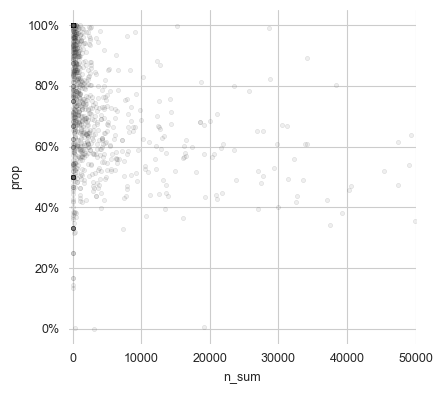

In [67]:
fig, ax = plt.subplots(figsize=(4.5, 4))

plt.box(False)

sns.scatterplot(data=df3, 
                x='n_sum', 
                y='prop',
                marker='.',
                alpha=.1,
                edgecolor='#000000',
                color='#666666')

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlim(-500, 50000)

plt.tight_layout()
plt.show()

In [68]:
openalex_pm_doctypes_journal = client.query(f"""
                SELECT oalex.type AS oalex_type, ptype AS pm_doctypes, 
                    primary_location.source.display_name AS journal, COUNT(DISTINCT(oalex.doi)) AS n
                FROM `subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022` AS pm
                JOIN `subugoe-collaborative.openalex.works` AS oalex
                ON LOWER(oalex.doi) = LOWER(pm.doi)
                GROUP BY oalex_type, pm_doctypes, journal
                ORDER BY n DESC
                """).to_dataframe()

In [69]:
openalex_pm_doctypes_journal['new_openalex_type'] = openalex_pm_doctypes_journal.apply(
                                                    lambda row : mapping_types(openalex_type_mapping, 
                                                                               row['oalex_type']), axis=1)
openalex_pm_doctypes_journal['new_pm_type'] = openalex_pm_doctypes_journal.apply(
                                                    lambda row : mapping_types(pubmed_type_mapping, 
                                                                               row['pm_doctypes']), axis=1)

openalex_pm_doctypes_journal
openalex_pm_doctypes_journal['type_match'] = (openalex_pm_doctypes_journal['new_openalex_type']) == (openalex_pm_doctypes_journal['new_pm_type'])
openalex_pm_doctypes_journal['type_match'] = openalex_pm_doctypes_journal['type_match'].astype(int)

df1 = openalex_pm_doctypes_journal[openalex_pm_doctypes_journal.type_match == 1].groupby(['journal'])['n'].sum().reset_index().rename(columns={'n': '1_sum'})
df2 = openalex_pm_doctypes_journal.groupby(['journal'])['n'].sum().reset_index().rename(columns={'n': 'n_sum'})
df3 = pd.merge(df1, df2, on='journal')
df3['prop'] = df3['1_sum'] / df3['n_sum']

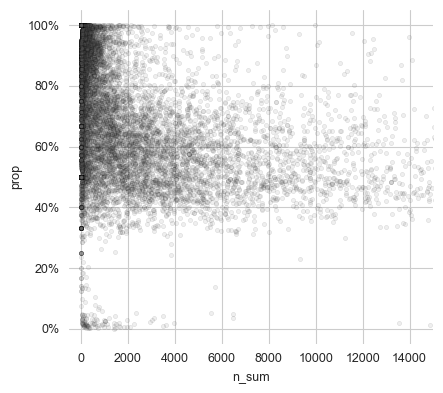

In [70]:
fig, ax = plt.subplots(figsize=(4.5, 4))

plt.box(False)

sns.scatterplot(data=df3, 
                x='n_sum', 
                y='prop',
                marker='.',
                alpha=.1,
                edgecolor='#000000',
                color='#666666')

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlim(-500, 15000)

plt.tight_layout()
plt.show()